# Predictive

In [1]:
import pandas as pd 

In [5]:
df_consumption = pd.read_excel("energy_sources.xlsx", sheet_name="energy consumption by sources", engine='openpyxl')

In [6]:
# Clean data

# get all data to same units
df_consumption['Biofuels - EJ'] = df_consumption['Biofuels (TWh)'].apply(lambda x: (x*3.6)/1000)

# get sum of consumption by year
df_consumption_by_year = df_consumption.groupby('Year').sum()

# remove data before 1965
df_consumption_by_year = df_consumption_by_year.drop(df_consumption_by_year.index[0:65])

# Merge columns of non renewable sources and renewable sources to 2 columns from df_consumption_by_year
df_consumption_by_year['Non Renewable - EJ'] = df_consumption_by_year['Coal Consumption - EJ'] + df_consumption_by_year['Oil Consumption - EJ'] + df_consumption_by_year['Gas Consumption - EJ'] + df_consumption_by_year['Nuclear Consumption - EJ'] + df_consumption_by_year['Hydro Consumption - EJ']
df_consumption_by_year['Renewable - EJ'] = df_consumption_by_year['Biofuels - EJ'] + df_consumption_by_year['Solar Consumption - EJ'] + df_consumption_by_year['Wind Consumption - EJ'] + df_consumption_by_year['Geo Biomass Other - EJ']

# get only the new columns
df_consumption_by_year = df_consumption_by_year[['Non Renewable - EJ', 'Renewable - EJ']]

df_consumption_by_year.describe().T

,count,mean,std,min,25%,50%,75%,max
Non Renewable - EJ,55.0,296061.921763,95898.357206,129564.068852,227984.065979,287893.133054,382426.149618,462420.435964
Renewable - EJ,55.0,3209.850510,4907.442981,149.877054,371.441158,1135.334359,3111.469999,20851.211907


### Consider renewable energy consumption

In [14]:
renewables = df_consumption_by_year[['Renewable - EJ']]

In [9]:
import matplotlib.pyplot as plt

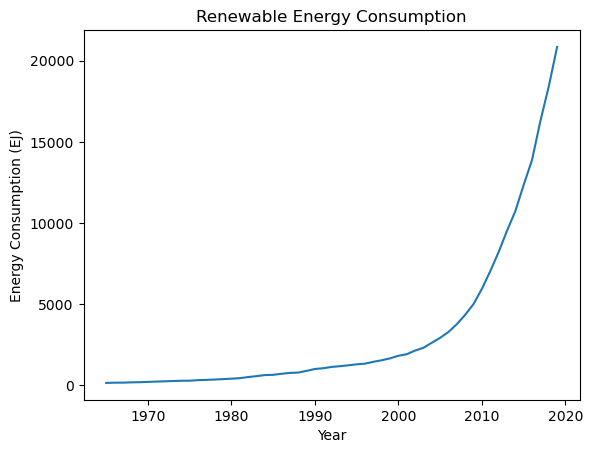

In [15]:
# plot dataset
# plt.plot(df_consumption_by_year.index, df_consumption_by_year['Non Renewable - EJ'], label='Non Renewable')
plt.plot(renewables.index, renewables['Renewable - EJ'], label='Renewable')

# header to graph as renewable consumption
plt.title('Renewable Energy Consumption')
plt.xlabel('Year')
plt.ylabel('Energy Consumption (EJ)')

plt.show()

In [36]:
# forecast annual energy consumption with random forest

from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [37]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = DataFrame(data)
 cols = list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
 # put it all together
 agg = concat(cols, axis=1)
 # drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg.values

In [38]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
 return data[:-n_test, :], data[-n_test:, :]

In [39]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
 # transform list into array
 train = asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = RandomForestRegressor(n_estimators=1000)
 model.fit(trainX, trainy)
 # make a one-step prediction
 yhat = model.predict([testX])
 return yhat[0]

In [40]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
 predictions = list()
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = random_forest_forecast(history, testX)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 error = mean_absolute_error(test[:, -1], predictions)
 return error, test[:, -1], predictions

In [41]:
values = renewables.values

In [46]:
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=10)
# data

In [47]:
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)

>expected=4351.2, predicted=3526.7
>expected=5016.7, predicted=4059.4
>expected=5952.3, predicted=4654.8
>expected=7038.9, predicted=5482.8
>expected=8216.9, predicted=6497.7
>expected=9523.2, predicted=7539.3
>expected=10736.8, predicted=8821.9
>expected=12353.8, predicted=10030.8
>expected=13889.5, predicted=11607.7
>expected=16290.1, predicted=13019.7
>expected=18411.0, predicted=15127.6
>expected=20851.2, predicted=17367.6
MAE: 2074.635


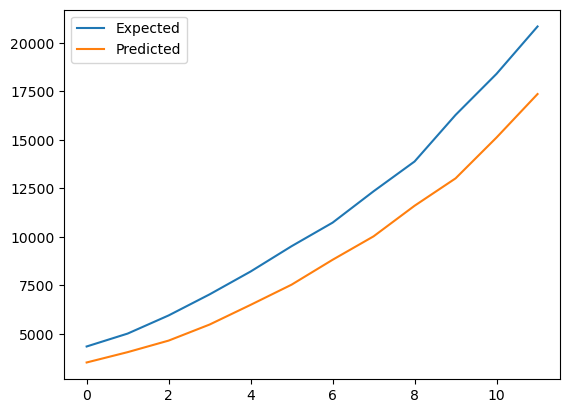

In [48]:
# plot expected vs predicted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()